In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
import math
import os
from tnn_utils import *

## MNIST data import 

In [18]:
#transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
transform = transforms.Compose([transforms.ToTensor()])
mnist_trainset = torchvision.datasets.MNIST(root="data", train=True, transform=transform)
mnist_testset = torchvision.datasets.MNIST(root="data", train=False, transform=transform)

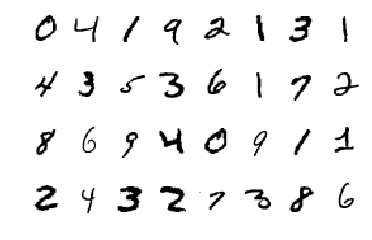

In [19]:
n_row, n_column = 4, 8
img_show(mnist_trainset, n_row, n_column)

In [20]:
mnist_trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=16, shuffle=True)
mnist_testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=16, shuffle=True)

In [6]:
imgs, labels = next(iter(mnist_trainloader))
print(imgs.shape)
print(labels.shape)

torch.Size([16, 1, 28, 28])
torch.Size([16])


In [45]:
def trans2grey(data_x, p):
    m = data_x.shape[0]
    for i in range(m):
        data_x[i][data_x[i]>p] = 1
        data_x[i][data_x[i]<=p] = 0
    
    return data_x

In [46]:
def data_preprocessing(mnist_data, p, index):
    data_list = []
    for imgs, labels in mnist_data:
        data = trans2grey(imgs, p)
        labels_onehot = one_hot(labels, index)
        data_list.append((data, labels_onehot))
    
    return data_list

In [47]:
data_list = data_preprocessing(mnist_trainloader, 0.5, 10)

## Building blocks of the Model

### Forward
\begin{align*}
&f^{l}(x) = \frac{1}{m}\sum_{i}{[A^{s_{1}}_{\alpha_{0}\alpha_{1}}\cdots A^{s_{n}}_{\alpha_{n-1}\alpha_{n}}\Phi^{s_{1}s_{2}\cdots s_{n}}(x^{i})]}\\
&L = \frac{1}{m}\sum_{i}{[f^{l}(x_{i}) - \delta^{l}_{n}]^{2}}
\end{align*}

In [9]:
def tnn_cell_forward_right(X, Y, parameters):
    m, n = X.shape
    tensors, l = parameters['tensors'], parameters['l']
    psi = torch.ones([m, 1, 1])
    assert l < n-1, "invalid l!"
    for site in range(l):
        psi = psi @ tensors[site][:, X[:, site], :].permute(1, 0, 2)
    left_psi = psi
    psi = psi @ tensors[l][:, X[:, l], :, :].permute(2, 1, 0, 3) @ tensors[l+1][:, X[:, l+1], :].permute(1, 0, 2)
    if l == n - 2:
        right_psi = torch.ones([m, 1, 1])
    else:
        right_psi = torch.ones([m, tensors[l+1].shape[2], tensors[l+1].shape[2]])
        for site in range(l+2, n):
            psi = psi @ tensors[site][:, X[:, site], :].permute(1, 0, 2)
            right_psi = right_psi @ tensors[site][:, X[:, site], :].permute(1, 0, 2)
    cache = (left_psi, right_psi, psi)
    loss = torch.sum(torch.pow(psi.squeeze()-Y.transpose(0, 1), 2)) / m
    return loss, cache

In [10]:
def tnn_cell_forward_left(X, Y, parameters):
    m, n = X.shape
    tensors, l = parameters['tensors'], parameters['l']
    psi = torch.ones([m, 1, 1])
    assert l > 0, "invalid l!"
    for site in range(l-1):
        psi = psi @ tensors[site][:, X[:, site], :].permute(1, 0, 2)
    left_psi = psi
    psi = psi @ tensors[l-1][:, X[:, l-1], :].permute(1, 0, 2) @ tensors[l][:, X[:, l], :, :].permute(2, 1, 0, 3)
    if l == n - 1:
        right_psi = torch.ones([m, 1, 1])
    else:
        right_psi = torch.ones([m, tensors[l].shape[3], tensors[l].shape[3]])
        for site in range(l+1, n):
            psi = psi @ tensors[site][:, X[:, site], :].permute(1, 0, 2)
            right_psi = right_psi @ tensors[site][:, X[:, site], :].permute(1, 0, 2)
    cache = (left_psi, right_psi, psi)
    loss = torch.sum(torch.pow(psi.squeeze()-Y.transpose(0, 1), 2)) / m
    return loss, cache

In [11]:
#test for tnn_cell_forward_right() module
torch.manual_seed(1)
m, n, l, index, Dmax = 5, 10, 8, 10, 10
parameters = {'m': m, 'n': n, 'Dmax': Dmax, 'index': index, 'l': l}
X = torch.randint(2, (m, n))
Y = np.random.binomial(index, 0.5, m)
Y_onehot = one_hot(Y, index)
parameters = tensor_initialize(parameters)
loss, cache = tnn_cell_forward_right(X, Y_onehot, parameters)
(left_psi, right_psi, psi) = cache
print("number of sample in one batch is: ", m)
print("number of features of one sample is: ", n)
print("output shape is: ", psi.shape)
print("shape of left tensor of Al is: ", left_psi.shape)
print("shape of right tensor of Al is: ", right_psi.shape)
print("the loss is: ", loss)
print("the psi is: ", psi.squeeze())

number of sample in one batch is:  5
number of features of one sample is:  10
output shape is:  torch.Size([10, 5, 1, 1])
shape of left tensor of Al is:  torch.Size([5, 1, 10])
shape of right tensor of Al is:  torch.Size([5, 1, 1])
the loss is:  tensor(1.0000)
the psi is:  tensor([[ 4.4382e-07,  2.4531e-09, -4.0748e-08,  5.3615e-07,  2.3963e-07],
        [ 3.2069e-07, -2.4423e-07, -4.7021e-08,  6.9442e-07, -1.3075e-07],
        [ 4.5649e-07,  5.2776e-09, -3.5951e-08,  2.7692e-07, -3.3417e-08],
        [ 5.3539e-07,  3.2677e-08,  2.2934e-08,  4.0646e-07,  3.6240e-08],
        [-5.3558e-07,  3.5996e-08, -1.1306e-07, -4.7360e-07,  8.8346e-09],
        [-1.7625e-08, -1.0136e-07, -3.0561e-08,  2.4733e-07, -1.3526e-07],
        [-1.2446e-07, -1.8450e-07, -5.7230e-08, -1.6109e-07, -3.4004e-08],
        [ 5.3043e-08, -4.6939e-08,  1.2409e-07,  6.1069e-08,  2.6866e-09],
        [-4.0068e-07,  8.3676e-08,  5.7593e-08, -2.0345e-07, -6.8020e-08],
        [ 1.5939e-07, -1.5154e-07, -1.9909e-08,  7.

In [12]:
#test for tnn_cell_forward_left() module
torch.manual_seed(1)
m, n, l, index, Dmax = 5, 15, 8, 10, 8
parameters = {'m': m, 'n': n, 'Dmax': Dmax, 'index': 10, 'l': l}
parameters = tensor_initialize(parameters)
X = torch.randint(1, (m, n))
loss, cache = tnn_cell_forward_left(X, Y_onehot, parameters)
(left_psi, right_psi, psi) = cache
print("number of sample in one batch is: ", m)
print("number of features of one sample is: ", n)
print("output shape is: ", psi.shape)
print("shape of left tensor of Al is: ", left_psi.shape)
print("shape of right tensor of Al is: ", right_psi.shape)
print("the loss is: ", loss)

number of sample in one batch is:  5
number of features of one sample is:  15
output shape is:  torch.Size([10, 5, 1, 1])
shape of left tensor of Al is:  torch.Size([5, 1, 8])
shape of right tensor of Al is:  torch.Size([5, 8, 1])
the loss is:  tensor(1.)


### Backward
\begin{align*}
&\frac{\partial{L}}{\partial{f^{l}(x^{(i)})}} = 2(f^{l}(x_{i}) - \delta^{l}_{n})\\
&\frac{\partial{f^{l}(x^{(i)})}}{\partial{B^{l,s_{k}s_{k+1}}_{\alpha_{k-1}\alpha_{k+1}}}} = \tilde{A}^{s_{1}s_{2}\cdots s_{k-1}}_{\alpha_{k-1}}\tilde{B}^{s_{k+2}\cdots s_{n}}_{\alpha_{k+1}}\Phi^{s_{1}s_{2}\cdots s_{n}}(x^{(i)})
\end{align*}

In [13]:
def tnn_cell_backward_right(X, Y, cache, parameters):
    """
    Calculate the gradients of the loss function wrt mps.
    
    Arguments:
    Y -- labels of the samples, pytorch tensor with dimension (m, index)
    
    Return:
    dAl -- gradient of the tensor, pytorch tensor with dimension (m, index, alpha_lf, alpha_rig)
    
    
    """
    left_psi, right_psi, psi = cache
    l =  parameters['l']
    left_index, right_index = left_psi.shape[-1], right_psi.shape[-2]
    m = X.shape[0]
    index = parameters['index']
    dfl = 2 * (psi - Y.reshape_as(psi))
    dBl_m = dfl * (left_psi.transpose(1, 2) @ right_psi.transpose(1, 2))
    index1, index2 = (X[:, l] == 0).view(1, -1, 1, 1), (X[:, l+1] == 0).view(1, -1, 1, 1)
    index3, index4 = 1 - index1, 1 - index2
    dBl_1 = (dBl_m * (index1 * index2).type(torch.float)).mean(1, True)
    dBl_2 = (dBl_m * (index1 * index4).type(torch.float)).mean(1, True)
    dBl_3 = (dBl_m * (index3 * index2).type(torch.float)).mean(1, True)
    dBl_4 = (dBl_m * (index3 * index4).type(torch.float)).mean(1, True)
    dBl = torch.cat((dBl_1, dBl_2, dBl_3, dBl_4), 1).reshape(index, 2, 2, left_index, right_index)
    #normalize dBl
    dBl /= dBl.norm()
    gradients = {'dBl': dBl}
    
    return gradients

In [14]:
def tnn_cell_backward_left(X, Y, cache, parameters):
    """
    Calculate the gradients of the loss function wrt mps.
    
    Arguments:
    Y -- labels of the samples, pytorch tensor with dimension (m, index)
    
    Return:
    dAl -- gradient of the tensor, pytorch tensor with dimension (m, index, alpha_lf, alpha_rig)
    
    
    """
    left_psi, right_psi, psi = cache
    l =  parameters['l']
    left_index, right_index = left_psi.shape[-1], right_psi.shape[-2]
    m = X.shape[0]
    index = parameters['index']
    dfl = 2 * (psi - Y.reshape_as(psi))
    dBl_m = dfl * (left_psi.transpose(1, 2) @ right_psi.transpose(1, 2))
    index1, index2 = (X[:, l-1] == 0).view(1, -1, 1, 1), (X[:, l] == 0).view(1, -1, 1, 1)
    index3, index4 = 1 - index1, 1 - index2
    dBl_1 = (dBl_m * (index1 * index2).type(torch.float)).mean(1, True)
    dBl_2 = (dBl_m * (index1 * index4).type(torch.float)).mean(1, True)
    dBl_3 = (dBl_m * (index3 * index2).type(torch.float)).mean(1, True)
    dBl_4 = (dBl_m * (index3 * index4).type(torch.float)).mean(1, True)
    dBl = torch.cat((dBl_1, dBl_2, dBl_3, dBl_4), 1).reshape(index, 2, 2, left_index, right_index)
    #normalize dBl
    dBl /= dBl.norm()    
    gradients = {'dBl': dBl}
    
    return gradients

In [15]:
#test for tnn_cell_backward_right()
gradients = tnn_cell_backward_right(X, Y_onehot, cache, parameters)
dBl = gradients['dBl']
print("shape of gradients of tensor Bl: ", dBl.shape)
print("gradients: ", dBl.squeeze())

shape of gradients of tensor Bl:  torch.Size([10, 2, 2, 8, 8])
gradients:  tensor([[[[[-3.6568e-10, -3.6568e-10, -3.6568e-10,  ..., -3.6568e-10,
            -3.6568e-10, -3.6568e-10],
           [-1.3997e-10, -1.3997e-10, -1.3997e-10,  ..., -1.3997e-10,
            -1.3997e-10, -1.3997e-10],
           [ 2.8723e-10,  2.8723e-10,  2.8723e-10,  ...,  2.8723e-10,
             2.8723e-10,  2.8723e-10],
           ...,
           [ 2.3679e-10,  2.3679e-10,  2.3679e-10,  ...,  2.3679e-10,
             2.3679e-10,  2.3679e-10],
           [-2.7697e-10, -2.7697e-10, -2.7697e-10,  ..., -2.7697e-10,
            -2.7697e-10, -2.7697e-10],
           [ 6.9051e-12,  6.9051e-12,  6.9051e-12,  ...,  6.9051e-12,
             6.9051e-12,  6.9051e-12]],

          [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+0

In [16]:
#test for tnn_cell_backward_left()
gradients = tnn_cell_backward_left(X, Y_onehot, cache, parameters)
dBl = gradients['dBl']
print("shape of gradients of tensor Bl: ", dBl.shape)
print("gradients: ", dBl.squeeze())

shape of gradients of tensor Bl:  torch.Size([10, 2, 2, 8, 8])
gradients:  tensor([[[[[-3.6568e-10, -3.6568e-10, -3.6568e-10,  ..., -3.6568e-10,
            -3.6568e-10, -3.6568e-10],
           [-1.3997e-10, -1.3997e-10, -1.3997e-10,  ..., -1.3997e-10,
            -1.3997e-10, -1.3997e-10],
           [ 2.8723e-10,  2.8723e-10,  2.8723e-10,  ...,  2.8723e-10,
             2.8723e-10,  2.8723e-10],
           ...,
           [ 2.3679e-10,  2.3679e-10,  2.3679e-10,  ...,  2.3679e-10,
             2.3679e-10,  2.3679e-10],
           [-2.7697e-10, -2.7697e-10, -2.7697e-10,  ..., -2.7697e-10,
            -2.7697e-10, -2.7697e-10],
           [ 6.9051e-12,  6.9051e-12,  6.9051e-12,  ...,  6.9051e-12,
             6.9051e-12,  6.9051e-12]],

          [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+0

\begin{align*}
\Delta B^{l,s_{k-1}s_{k}}_{\alpha_{k-1}\alpha_{k+1}}\to
\begin{bmatrix}
B^{l,x_{m}}_{\alpha_{k-1}\alpha_{k+1}}\\
\cdots\\
B^{l,x_{n}}_{\alpha_{k-1}\alpha_{k+1}}
\end{bmatrix}
\end{align*}

In [17]:
def update_parameters_right(X, parameters, gradients, bond, learning_rate):
    
    n, index, tensors, l = parameters['n'], parameters['index'], parameters['tensors'], parameters['l']
    assert l < n, "invalid l"
    dBl = gradients['dBl']
    Bl = tensors[l].permute(2, 1, 0, 3).unsqueeze(2) @ tensors[l+1].permute(1, 0, 2).unsqueeze(0)
    Bl +=  learning_rate * dBl
    alpha_left, alpha_right = dBl.shape[-2], dBl.shape[-1]
    u, s, vt = torch.svd(Bl.permute(1, 3, 0, 2, 4).contiguous().view(2*alpha_left, 2*alpha_right*index))
    if alpha_left * 2 > bond:
        tensors[l] = ((u * s).split(bond, 1)[0]).reshape(2, alpha_left, bond).permute(1, 0, 2)
        tensors[l+1] = (((vt.transpose(0, 1)).split(bond, 0))[0]).reshape(bond, index, 2, alpha_right).permute(0, 2, 1, 3)
    else:    
        tensors[l] = (u * s).reshape(2, alpha_left, -1).permute(1, 0, 2)
        tensors[l+1] = (vt.transpose(0, 1)).reshape(-1, index, 2, alpha_right).permute(0, 2, 1, 3)
    parameters['l'] = l + 1      
    
    return parameters  

In [18]:
def update_parameters_left(X, parameters, gradients, bond, learning_rate):
    
    n, index, tensors, l = parameters['n'], parameters['index'], parameters['tensors'], parameters['l']
    assert l > 0, "invalid l"
    dBl = gradients['dBl']
    Bl = tensors[l-1].permute(1, 0, 2).unsqueeze(1) @ tensors[l].permute(2, 1, 0, 3).unsqueeze(1)
    Bl +=  learning_rate * dBl
    alpha_left, alpha_right = dBl.shape[-2], dBl.shape[-1]        
    u, s, vt = torch.svd(Bl.permute(1, 3, 0, 2, 4).contiguous().view(2*alpha_left*index, 2*alpha_right))
    if alpha_right * 2 > bond:
        tensors[l-1] = ((u * s).split(bond, 1)[0]).reshape(2, alpha_left, index, bond).permute(1, 0, 2, 3)
        tensors[l] = ((vt.transpose(0, 1).split(bond, 0))[0]).reshape(bond, 2, alpha_right)
    else:
        tensors[l-1] = (u * s).reshape(2, alpha_left, index, -1).permute(1, 0, 2, 3)
        tensors[l] = vt.transpose(0, 1).reshape(-1, 2, alpha_right)
    parameters['l'] = l - 1
    
    return parameters  

In [19]:
#test for update_parameters_right()
torch.manual_seed(1)
m, n, l, index, Dmax = 5, 10, 0, 10, 15
parameters = {'m': m, 'n': n, 'Dmax': Dmax, 'index': 10, 'l': l}
parameters = tensor_initialize(parameters)
X = torch.randint(1, (m, n))
Y = np.random.binomial(index, 0.5, m)
Y_onehot = one_hot(Y, index)
loss, cache = tnn_cell_forward_right(X, Y_onehot, parameters)
(left_psi, right_psi, psi) = cache
gradients = tnn_cell_backward_right(X, Y_onehot, cache, parameters)
bond, learning_rate, n = 3, 0.01, parameters['n']
parameters = update_parameters_right(X, parameters, gradients, bond, learning_rate)
tensors = parameters['tensors']
print("shape of updated A^{l} tensor: ", tensors[l].shape)
print("shape updated A^{l+1} tensor: ", tensors[l+1].shape)
for i in range(n):
    print(tensors[i].shape)
print("updated A^{l} tensor: ", tensors[l])

shape of updated A^{l} tensor:  torch.Size([1, 2, 2])
shape updated A^{l+1} tensor:  torch.Size([2, 2, 10, 15])
torch.Size([1, 2, 2])
torch.Size([2, 2, 10, 15])
torch.Size([15, 2, 15])
torch.Size([15, 2, 15])
torch.Size([15, 2, 15])
torch.Size([15, 2, 15])
torch.Size([15, 2, 15])
torch.Size([15, 2, 15])
torch.Size([15, 2, 15])
torch.Size([15, 2, 1])
updated A^{l} tensor:  tensor([[[-0.1750,  0.0950],
         [ 0.1115,  0.1491]]])


In [20]:
#test for update_parameters_left()
torch.manual_seed(1)
m, n, l, index, Dmax = 5, 10, 9, 10, 15
parameters = {'m': m, 'n': n, 'Dmax': Dmax, 'index': 10, 'l': l}
parameters = tensor_initialize(parameters)
X = torch.randint(1, (m, n))
Y = np.random.binomial(index, 0.5, m)
Y_onehot = one_hot(Y, index)
loss, cache = tnn_cell_forward_left(X, Y_onehot, parameters)
(left_psi, right_psi, psi) = cache
gradients = tnn_cell_backward_left(X, Y_onehot, cache, parameters)
bond, learning_rate, n = 10, 0.01, parameters['n']
parameters = update_parameters_left(X, parameters, gradients, bond, learning_rate)
tensors = parameters['tensors']
print("shape of updated A^{l} tensor: ", tensors[l].shape)
print("updated A^{l-1} tensor: ", tensors[l-1].shape)
for i in range(n):
    print(tensors[i].shape)
print("updated A^{l-1} tensor: ", tensors[l-1])

shape of updated A^{l} tensor:  torch.Size([2, 2, 1])
updated A^{l-1} tensor:  torch.Size([15, 2, 10, 2])
torch.Size([1, 2, 15])
torch.Size([15, 2, 15])
torch.Size([15, 2, 15])
torch.Size([15, 2, 15])
torch.Size([15, 2, 15])
torch.Size([15, 2, 15])
torch.Size([15, 2, 15])
torch.Size([15, 2, 15])
torch.Size([15, 2, 10, 2])
torch.Size([2, 2, 1])
updated A^{l-1} tensor:  tensor([[[[-1.2375e-02,  1.3121e-02],
          [-1.0831e-02, -4.5033e-03],
          [ 9.3241e-03,  6.9389e-03],
          [-7.4958e-03,  9.6316e-04],
          [-5.4439e-03, -6.4347e-03],
          [-1.3136e-02, -6.4618e-03],
          [ 2.5098e-02,  1.0793e-02],
          [ 1.0865e-02, -4.2328e-03],
          [-2.5274e-04,  1.5520e-02],
          [-2.6992e-03,  2.9070e-03]],

         [[ 2.1382e-03, -6.1618e-03],
          [-3.8696e-03, -5.7640e-03],
          [ 2.4329e-03,  7.5532e-03],
          [-6.8987e-03, -1.5350e-02],
          [-1.5761e-03, -7.5634e-03],
          [-2.0055e-02,  9.8206e-03],
          [-2.5464e

In [21]:
def optimize(X, Y, parameters, bond, learning_rate=0.01):
    
    n, l, Dmax = parameters['n'], parameters['l'], parameters['Dmax']
    parameters = tensor_initialize(parameters)
    for i in range(l, n-1):
        loss, cache = tnn_cell_forward_right(X, Y, parameters)
        gradients = tnn_cell_backward_right(X, Y, cache, parameters)
        parameters = update_parameters_right(X, parameters, gradients, bond, learning_rate)
    for i in range(n, 1, -1):
        loss, cache = tnn_cell_forward_left(X, Y, parameters)
        gradients = tnn_cell_backward_left(X, Y, cache, parameters)
        parameters = update_parameters_left(X, parameters, gradients, bond, learning_rate)
        
    return parameters, loss, gradients

In [22]:
#test for optimize()
torch.manual_seed(1)
m, n, l, index, Dmax, bond = 15, 25, 2, 10, 10, 8
X = torch.randint(1, (m, n))
Y = np.random.binomial(index, 0.5, m)
Y_onehot = one_hot(Y, index)
parameters = {'m': m, 'n': n, 'Dmax': Dmax, 'index': index, 'l': l}
parameters, loss, gradients = optimize(X, Y_onehot, parameters, bond, learning_rate)
n, tensors = parameters['n'], parameters['tensors']
dAl = gradients['dBl']
for i in range(n):
    print(parameters['tensors'][i].shape)
print(dAl.shape)
print(dAl)

torch.Size([1, 2, 10, 8])
torch.Size([8, 2, 8])
torch.Size([8, 2, 8])
torch.Size([8, 2, 8])
torch.Size([8, 2, 8])
torch.Size([8, 2, 8])
torch.Size([8, 2, 8])
torch.Size([8, 2, 8])
torch.Size([8, 2, 8])
torch.Size([8, 2, 8])
torch.Size([8, 2, 8])
torch.Size([8, 2, 8])
torch.Size([8, 2, 8])
torch.Size([8, 2, 8])
torch.Size([8, 2, 8])
torch.Size([8, 2, 8])
torch.Size([8, 2, 8])
torch.Size([8, 2, 8])
torch.Size([8, 2, 8])
torch.Size([8, 2, 8])
torch.Size([8, 2, 8])
torch.Size([8, 2, 8])
torch.Size([8, 2, 4])
torch.Size([4, 2, 2])
torch.Size([2, 2, 1])
torch.Size([10, 2, 2, 1, 8])
tensor([[[[[0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707, 0.0707]],

          [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]],


         [[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

          [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]]],



        [[[[0.1414, 0.1414, 0.1414, 0.1414, 0.1414, 0.1414, 0.1414, 0.1414]],

          [[0.00

In [23]:
def model(data, num_epochs, n, Dmax, l, index, bond, learning_rate):
    parameters = {'n': n, 'Dmax': Dmax, 'index': index, 'l': l}
    parameters = tensor_initialize(parameters)
    
    for i in range(num_epochs):
        j = 0
        for images, labels in data:
            images = images.view(images.shape[0], -1)
            labels_onehot = one_hot(labels, index) 
            images.type(torch.long)
            parameters, loss, gradients = optimize(images.type(torch.long), lables_onehot, parameters, bond, learning_rate)
            j = j + 1
            if j % 20 == 0:           
                print("Iteration: %d, Loss: %f" % (j, loss) + '\n')
            
    return parameters

In [ ]:
parameters = model(mnist_trainloader, 2, 28*28, 20, 0, 10, 10, 0.01)

In [26]:
parameters = {'n': 28*28, 'Dmax': 20, 'index': 10, 'l': 0}
bond = 20
learning_rate = 0.01
parameters = tensor_initialize(parameters)
images, labels = next(iter(mnist_trainloader))
images = images.view(images.shape[0], -1)
lables_onehot = one_hot(labels, index) 
images.type(torch.long)
loss, cache = tnn_cell_forward_right(images.type(torch.long), labels_onehot, parameters)
#parameters, loss, gradients = optimize(images.type(torch.long), lables_onehot, parameters, bond, learning_rate)

In [27]:
lables_onehot = one_hot(labels, index)

In [28]:
images.type(torch.long)

tensor([[-1, -1, -1,  ..., -1, -1, -1],
        [-1, -1, -1,  ..., -1, -1, -1],
        [-1, -1, -1,  ..., -1, -1, -1],
        ...,
        [-1, -1, -1,  ..., -1, -1, -1],
        [-1, -1, -1,  ..., -1, -1, -1],
        [-1, -1, -1,  ..., -1, -1, -1]])

In [25]:
loss

tensor(1.)

In [ ]:
loss

In [ ]:
cache

In [ ]:
x

In [22]:
data = iter(mnist_trainloader)
imgs, lables = next(data)

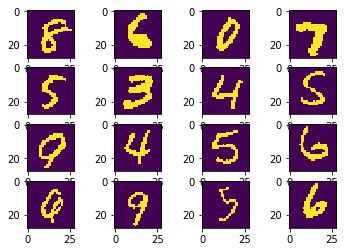

In [30]:
for i in range(imgs.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(imgs[i].squeeze())

In [29]:
for i in range(imgs.shape[0]):
    imgs[i][imgs[i]>0.5] = 1
    imgs[i][imgs[i]<=0.5] = 0